In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/energy-consumption-time-series-dataset/KwhConsumptionBlower78_1.csv
/kaggle/input/energy-consumption-time-series-dataset/KwhConsumptionBlower78_2.csv
/kaggle/input/energy-consumption-time-series-dataset/KwhConsumptionBlower78_3.csv


In [2]:

res = []
for dirname,_,filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filepath = os.path.join(dirname,filename)
        print(filepath)
        res.append(
            pd.read_csv(
                filepath,
                names=['id','date','time','consumption'],
                parse_dates= {'datetime':['date','time']},
                index_col='id',
                header=0,
                date_parser=lambda x,y: pd.to_datetime(x+' '+y,format='%d %b %Y %H:%M:%S')
            )
        )

/kaggle/input/energy-consumption-time-series-dataset/KwhConsumptionBlower78_1.csv
/kaggle/input/energy-consumption-time-series-dataset/KwhConsumptionBlower78_2.csv
/kaggle/input/energy-consumption-time-series-dataset/KwhConsumptionBlower78_3.csv


In [3]:
df = pd.concat(res,ignore_index=True).sort_values('datetime')

In [4]:
df.head()

,datetime,consumption
43,2022-01-01 00:22:28,1.030
19,2022-01-01 00:42:33,0.904
25,2022-01-01 01:01:51,0.904
11,2022-01-01 01:41:48,1.850
29,2022-01-01 02:22:52,1.878


In [5]:
print(f"min date: {df['datetime'].min()}, max date: {df['datetime'].max()}")
print(f"range: {df['datetime'].max()-df['datetime'].min()}")

min date: 2022-01-01 00:22:28, max date: 2022-02-28 23:50:27
range: 58 days 23:27:59


In [6]:
#daily energy consumption
df.sort_values('datetime').rolling('1D',on='datetime').sum().head()

,datetime,consumption
43,2022-01-01 00:22:28,1.030
19,2022-01-01 00:42:33,1.934
25,2022-01-01 01:01:51,2.838
11,2022-01-01 01:41:48,4.688
29,2022-01-01 02:22:52,6.566


<AxesSubplot:title={'center':'Hourly energy consumption'}, xlabel='datetime'>

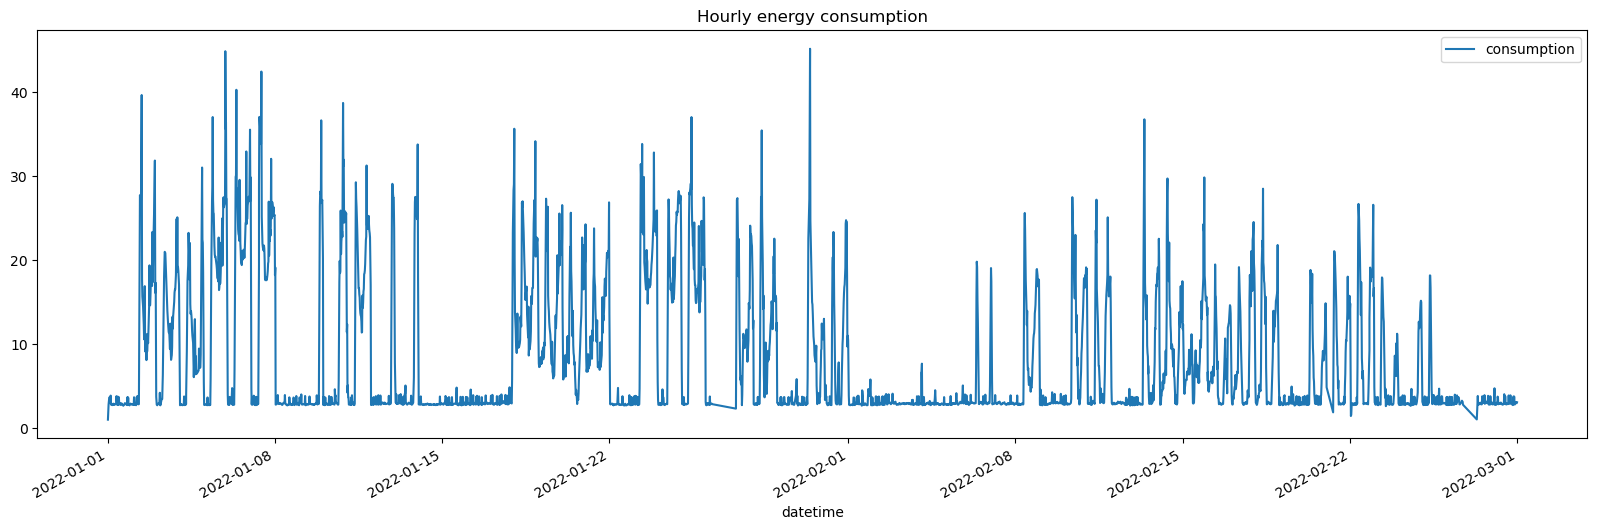

In [7]:
import matplotlib.pyplot as plt
df.rolling('1H',on='datetime').sum().loc[df['consumption']>0.5].plot(x='datetime',y='consumption',title="Hourly energy consumption",figsize=(20,6))

In [8]:
# Monthly total consumption and daily average consumption for a month
daily_cons = df.rolling('1d',on='datetime').sum()
daily_cons.groupby(daily_cons['datetime'].dt.month)['consumption'].apply(lambda x: {'sum':x.sum(),'average':x.mean(),'count':x.count()})

datetime         
1         sum        394803.692000
          average       212.488532
          count        1858.000000
2         sum        230673.132000
          average       131.964034
          count        1748.000000
Name: consumption, dtype: float64

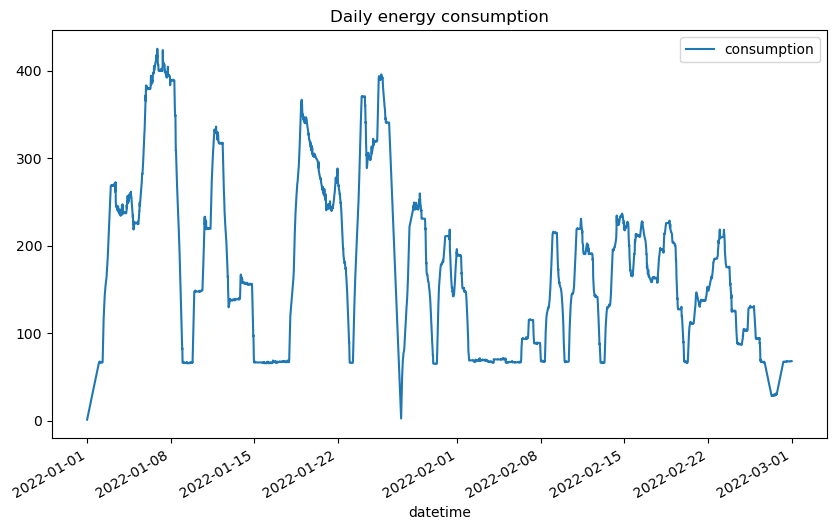

In [9]:


daily_cons.plot(x='datetime',y='consumption',title="Daily energy consumption",figsize=(10,6))
plt.show()

In [10]:
daily_cons.describe()

,consumption
count,3606.000000
mean,173.454471
std,96.549275
min,1.030000
25%,81.581500
50%,159.762000
75%,230.291500
max,425.264000


In [11]:
#Separating day and night consumption time

day_consumption = df.loc[(pd.Timestamp('06:00').time()<=df['datetime'].dt.time)&(df['datetime'].dt.time<pd.Timestamp('18:00').time())&(df['consumption']>0.5)]
night_consumption = df.loc[set(df.index)-set(day_consumption.index)].sort_values('datetime')
night_consumption = night_consumption.loc[night_consumption['consumption']>0.5]

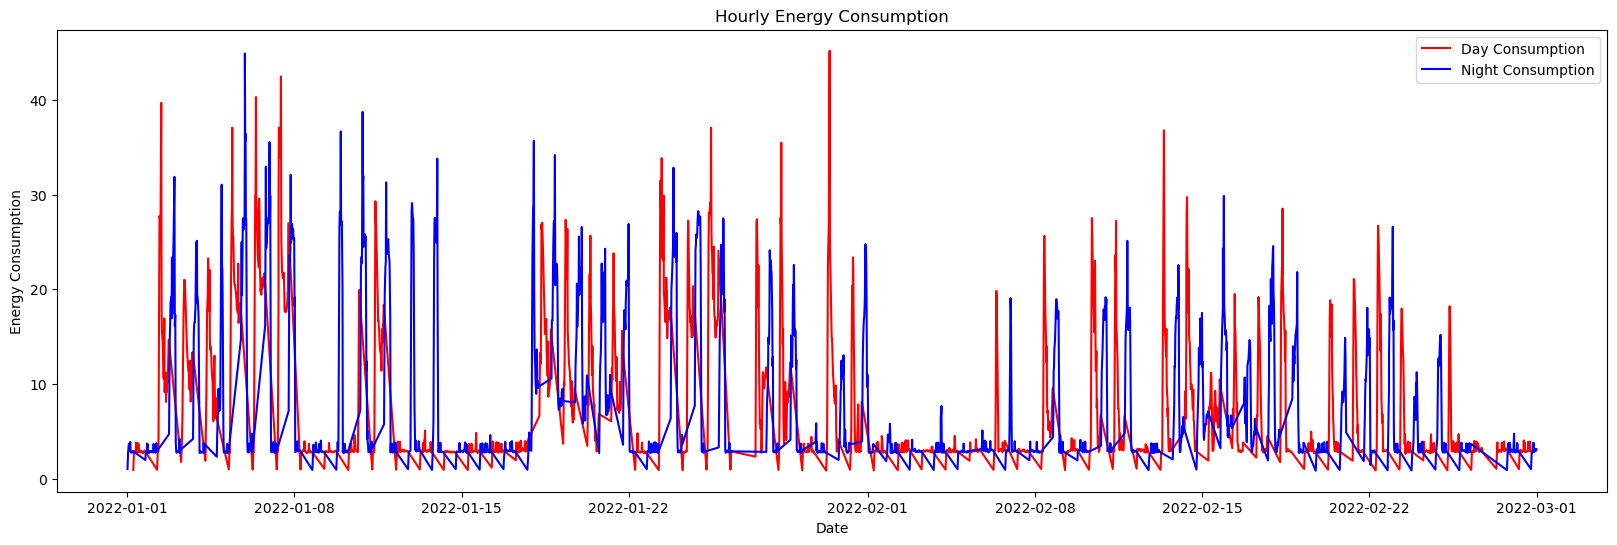

In [12]:
fig,ax= plt.subplots(1,1,figsize=(20,6))
day_hourly_cons = day_consumption.rolling('1H',on='datetime').sum()
night_hourly_cons = night_consumption.rolling('1H',on='datetime').sum()
ax.plot(day_hourly_cons['datetime'],day_hourly_cons['consumption'],'r-',label='Day Consumption')
ax.plot(night_hourly_cons['datetime'],night_hourly_cons['consumption'],'b-',label='Night Consumption')
ax.legend()
ax.set_title("Hourly Energy Consumption")
ax.set_xlabel("Date")
ax.set_ylabel("Energy Consumption")
plt.show()

In [13]:
daily_day_cons= day_consumption.rolling('1d',on='datetime').sum()
daily_night_cons= night_consumption.rolling('1d',on='datetime').sum()

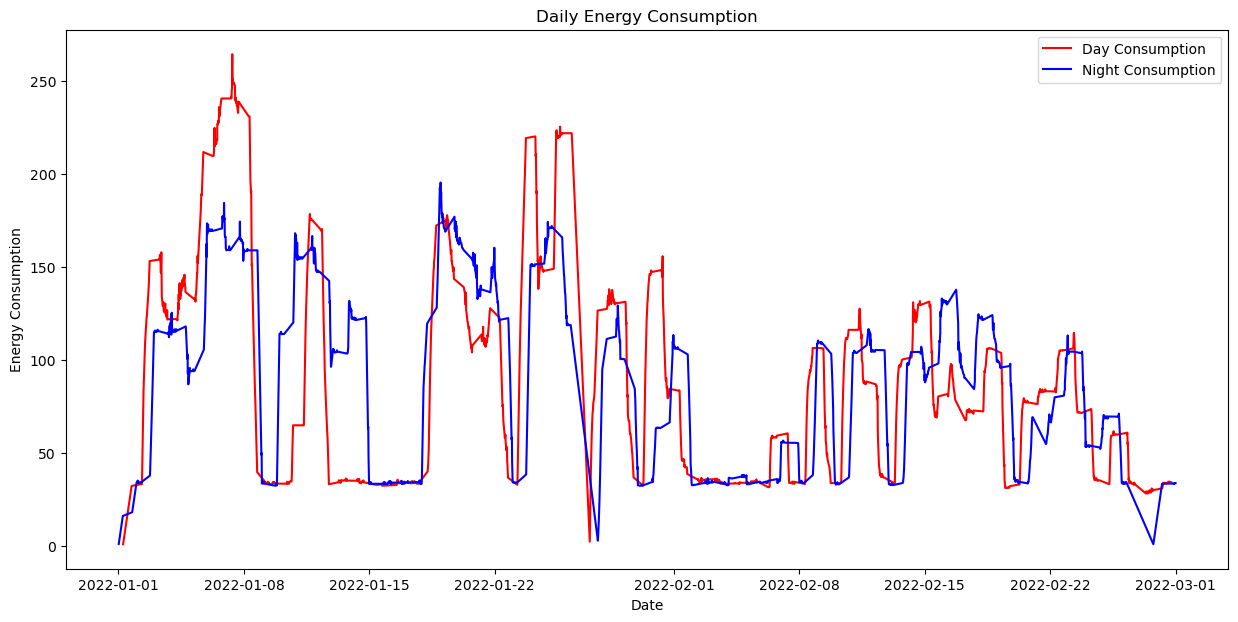

In [14]:
fig,ax= plt.subplots(1,1,figsize=(15,7))

ax.plot(daily_day_cons['datetime'],daily_day_cons['consumption'],'r-',label='Day Consumption')
ax.plot(daily_night_cons['datetime'],daily_night_cons['consumption'],'b-',label='Night Consumption')
ax.legend()
ax.set_title("Daily Energy Consumption")
ax.set_xlabel("Date")
ax.set_ylabel("Energy Consumption")
plt.show()

# **TimeSeries Forecasting**

In [15]:
#Aggregating to day 

df_copy = df.set_index('datetime').sort_index()
df_copy = df_copy.resample('1D').sum()

**Additive Decompostion**

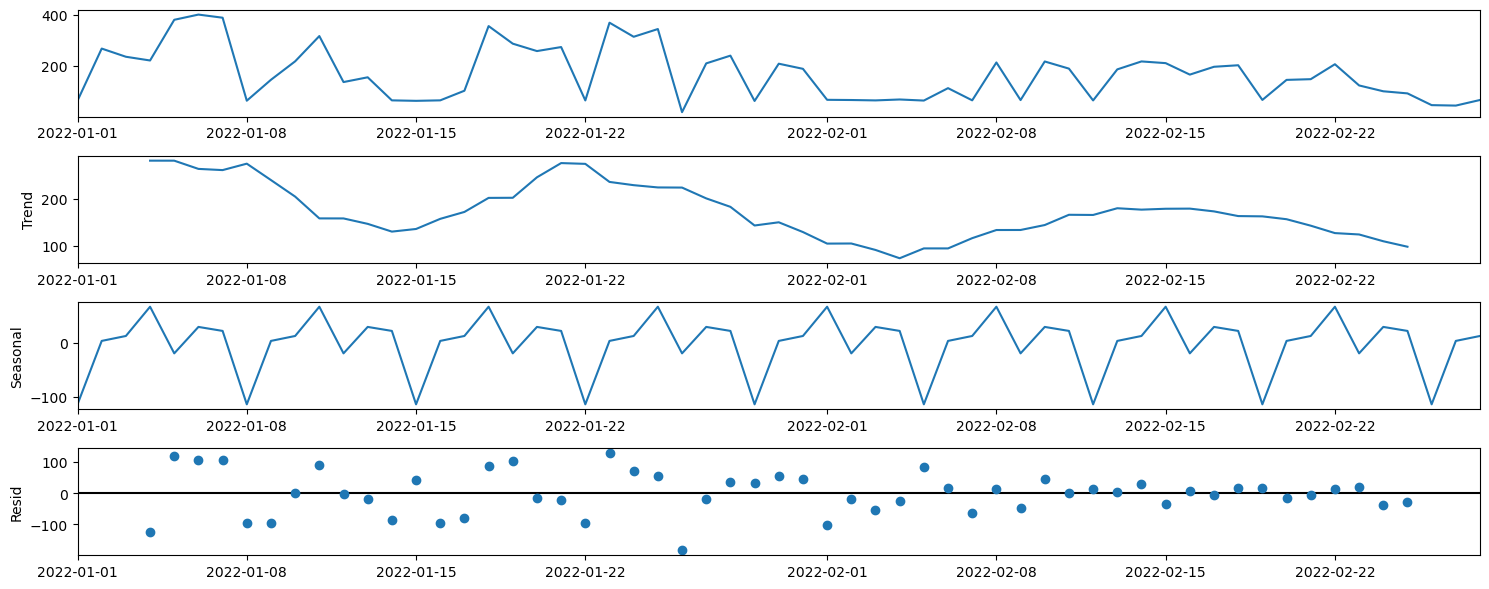

In [16]:
#TimeSeries Additive Decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_copy,model='additive')
plt.rc("figure", figsize=(15,6))
result.plot()
plt.show()

**Multiplicative Decomposition**

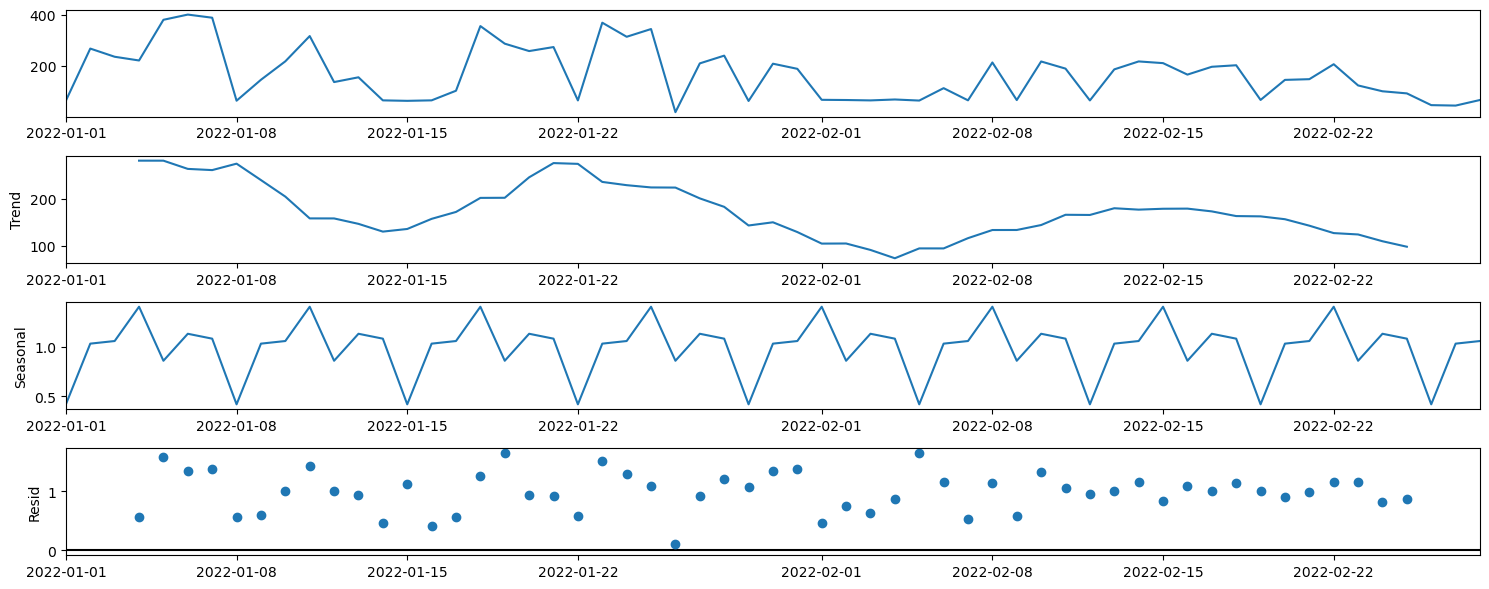

In [17]:
#TimeSeries Multiplitive Decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_copy,model='multiplicative')
plt.rc("figure", figsize=(15,6))
result.plot()
plt.show()

# AutoRegression Forecasting

In [18]:
#AutoRegression Forecasting

from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(df_copy,lags=15)
model_fit = model.fit()

next_one_m = model_fit.predict('2022-03-01','2022-03-31')

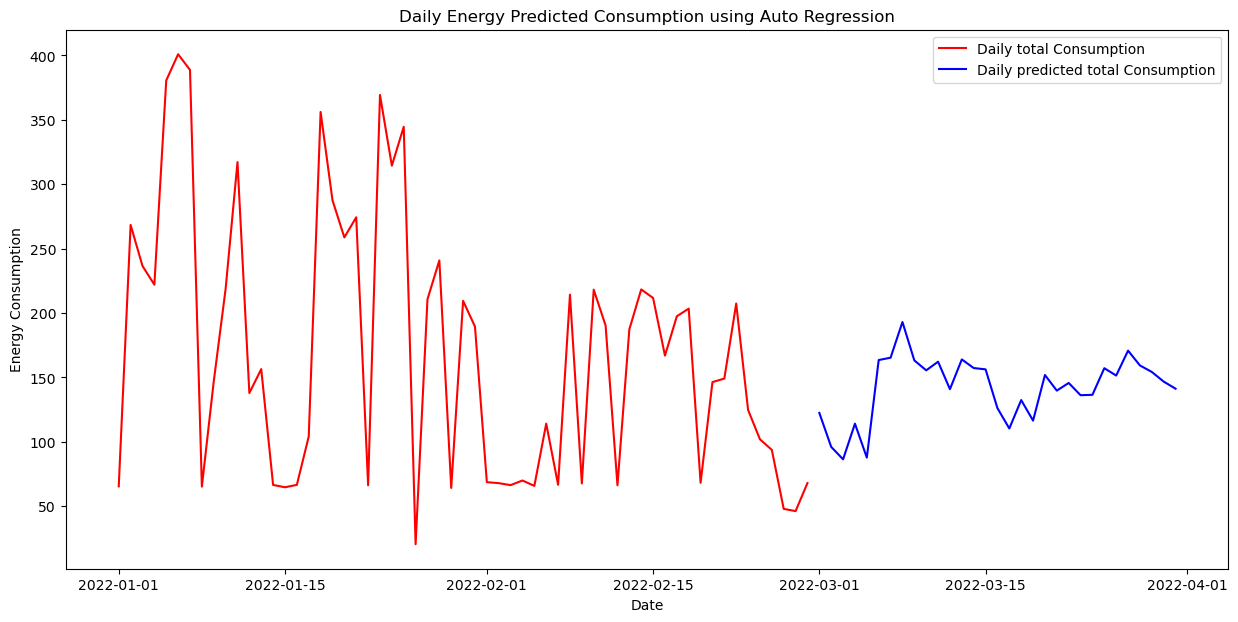

In [19]:
fig,ax= plt.subplots(1,1,figsize=(15,7))

ax.plot(df_copy['consumption'],'r-',label='Daily total Consumption')
ax.plot(next_one_m,'b-',label='Daily predicted total Consumption')
ax.legend()
ax.set_title("Daily Energy Predicted Consumption using Auto Regression")
ax.set_xlabel("Date")
ax.set_ylabel("Energy Consumption")
plt.show()

# **Moving Average Forecasting**

In [20]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_copy,order=(0,0,1))
model_fit = model.fit()

next_one_m = model_fit.predict('2022-03-01','2022-03-31')


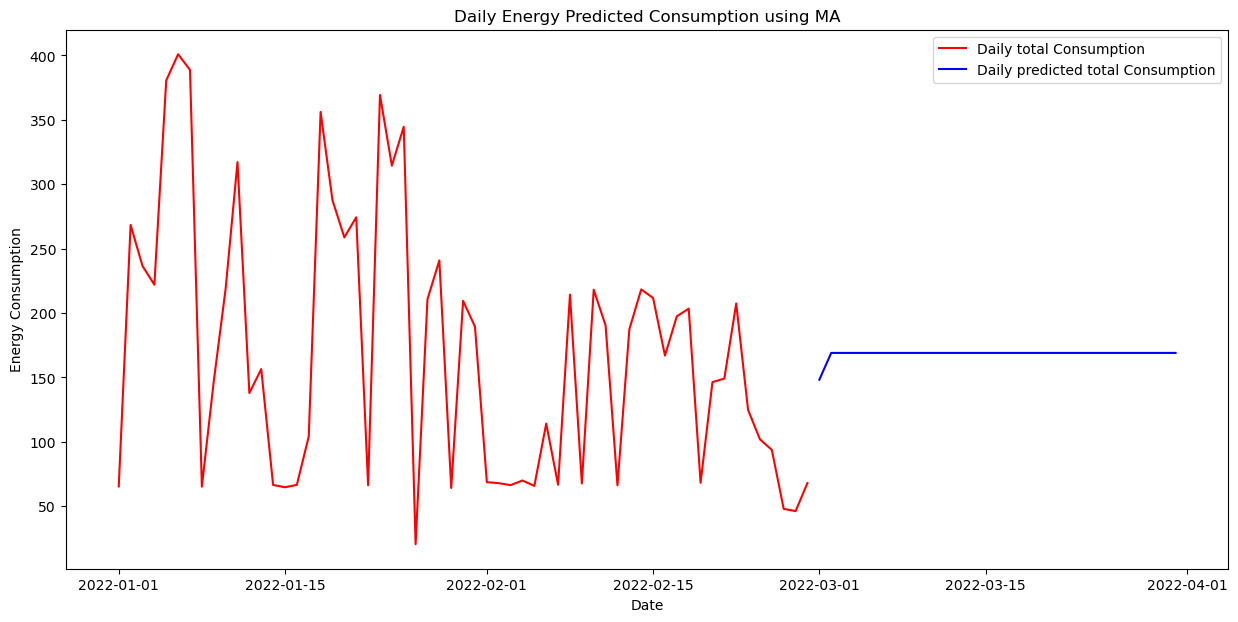

In [21]:
fig,ax= plt.subplots(1,1,figsize=(15,7))

ax.plot(df_copy['consumption'],'r-',label='Daily total Consumption')
ax.plot(next_one_m,'b-',label='Daily predicted total Consumption')
ax.legend()
ax.set_title("Daily Energy Predicted Consumption using MA")
ax.set_xlabel("Date")
ax.set_ylabel("Energy Consumption")
plt.show()

# **Autoregressive Moving Average (ARMA)**

In [22]:
model = ARIMA(df_copy,order=(9,0,1))
model_fit = model.fit()

next_one_m = model_fit.predict('2022-03-01','2022-03-31')

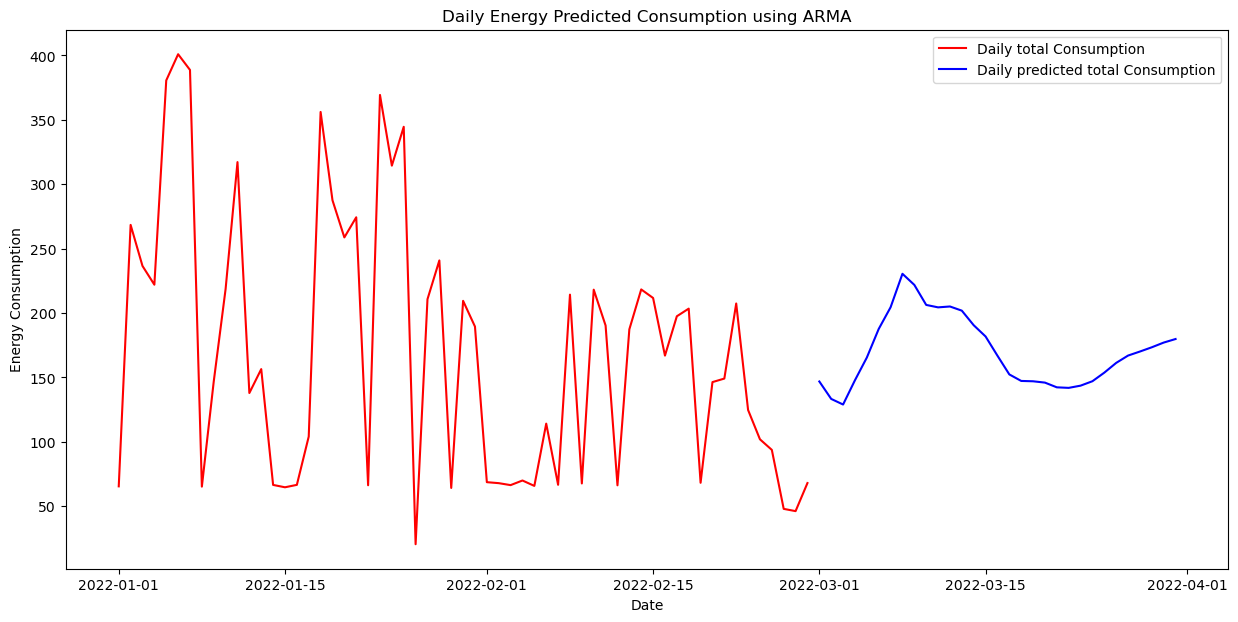

In [23]:
fig,ax= plt.subplots(1,1,figsize=(15,7))

ax.plot(df_copy['consumption'],'r-',label='Daily total Consumption')
ax.plot(next_one_m,'b-',label='Daily predicted total Consumption')
ax.legend()
ax.set_title("Daily Energy Predicted Consumption using ARMA")
ax.set_xlabel("Date")
ax.set_ylabel("Energy Consumption")
plt.show()

# **Autoregressive Integrated Moving Average (ARIMA)**

In [24]:
model = ARIMA(df_copy,order=(10,1,1))
model_fit = model.fit()

next_one_m = model_fit.predict('2022-03-01','2022-03-31')

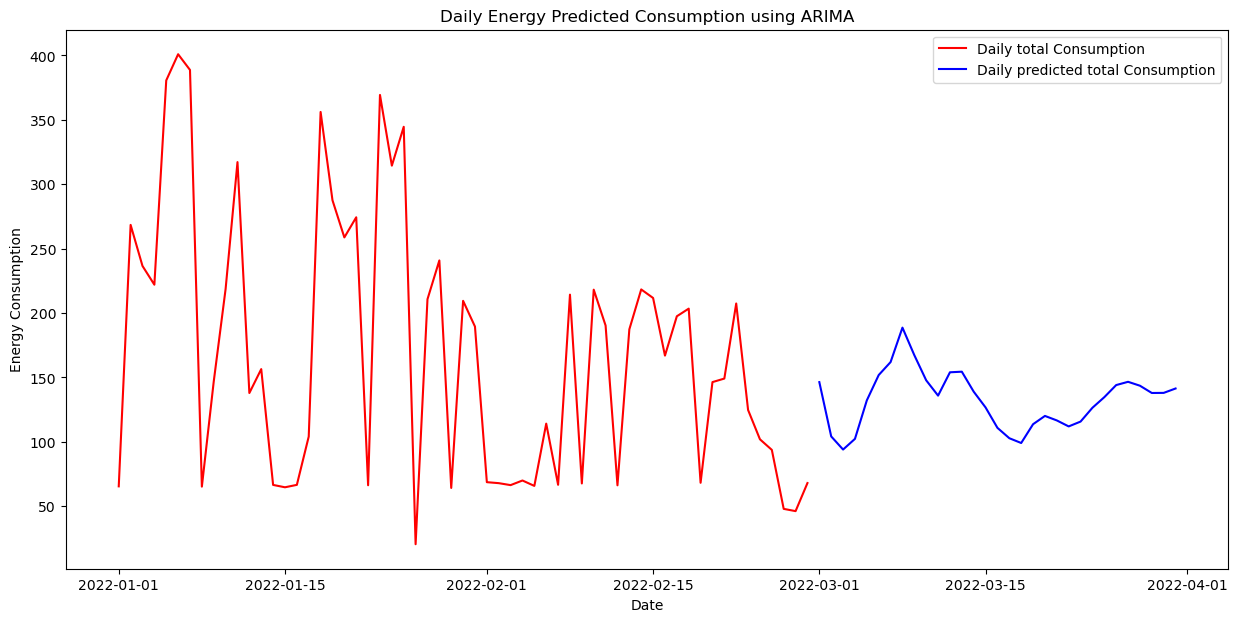

In [25]:
fig,ax= plt.subplots(1,1,figsize=(15,7))

ax.plot(df_copy['consumption'],'r-',label='Daily total Consumption')
ax.plot(next_one_m,'b-',label='Daily predicted total Consumption')
ax.legend()
ax.set_title("Daily Energy Predicted Consumption using ARIMA")
ax.set_xlabel("Date")
ax.set_ylabel("Energy Consumption")
plt.show()

# **Seasonal Autoregressive Integrated Moving Average (SARIMA)**

In [26]:
model = ARIMA(df_copy,order=(5,1,1),seasonal_order=(1,0,1,7))
model_fit = model.fit()

next_one_m = model_fit.predict('2022-03-01','2022-03-31')

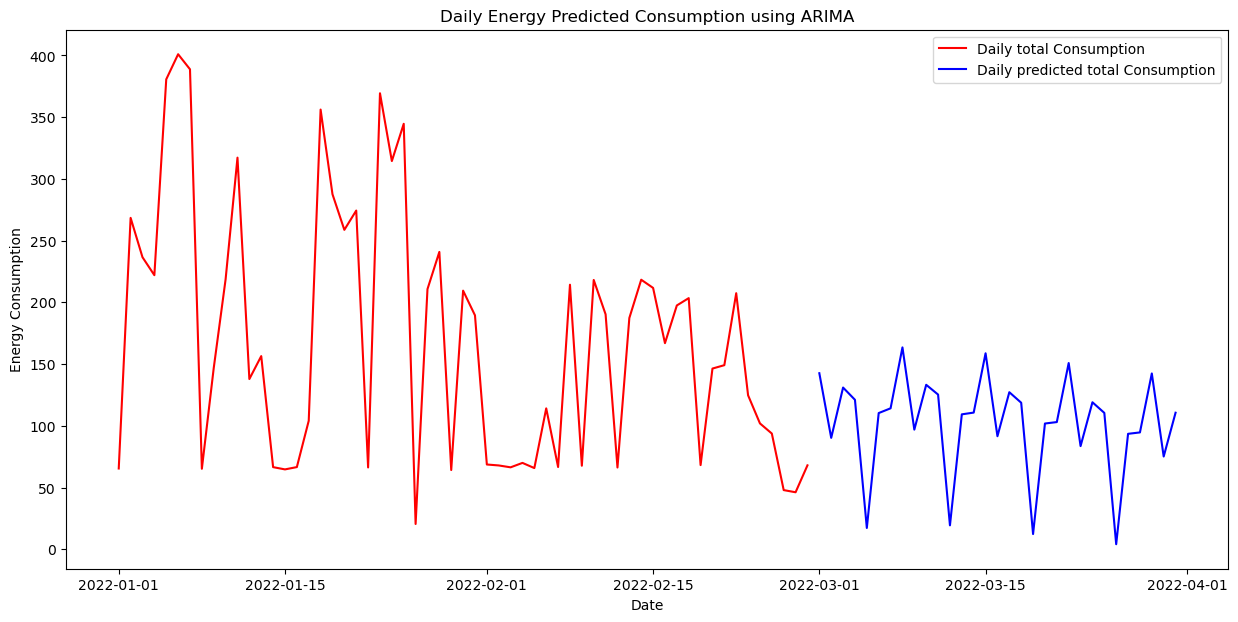

In [27]:
fig,ax= plt.subplots(1,1,figsize=(15,7))

ax.plot(df_copy['consumption'],'r-',label='Daily total Consumption')
ax.plot(next_one_m,'b-',label='Daily predicted total Consumption')
ax.legend()
ax.set_title("Daily Energy Predicted Consumption using ARIMA")
ax.set_xlabel("Date")
ax.set_ylabel("Energy Consumption")
plt.show()